In [4]:
import sympy as sp
from sympy import factorial, Matrix, prod
import itertools
import numba as nb


def mv_series(function_expression, variable_list, evaluation_point, degree):
    """
    Calculate the multivariate Taylor polynomial using SymPy.

    Parameters
    ----------
    function_expression : sympy.Expr
        Sympy expression of the function.
    variable_list : list of sympy.Symbol
        List of variables to be approximated (to be "Taylorized").
    evaluation_point : list of float
        Coordinates where the function will be expressed.
    degree : int
        Total degree of the Taylor polynomial.

    Returns
    -------
    sympy.Expr
        Returns a Sympy expression of the Taylor series up to a given degree,
        of a given multivariate expression, approximated as a multivariate polynomial
        evaluated at the evaluation_point.

    References
    ----------
    - Mathematical formulation reference:
      https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Multivariable_Calculus/3%3A_Topics_in_Partial_Derivatives/Taylor__Polynomials_of_Functions_of_Two_Variables
    """
    n_var = len(variable_list)
    point_coordinates = [(i, j) for i, j in zip(variable_list, evaluation_point)]

    polynomial = 0

    for total_degree in range(degree + 1):
        for indices in itertools.combinations_with_replacement(range(n_var), total_degree):
            deriv_orders_as_input = list(sum(zip(variable_list[i] for i in indices), ()))

            # Check if the partial derivative is needed (relevant terms are present in the equation)
            if any(function_expression.has(sym) for sym in deriv_orders_as_input):
                partial_derivative = sp.diff(function_expression, *deriv_orders_as_input).subs(
                    point_coordinates
                )

                # Check if the partial derivative is non-zero at the evaluation point
                if partial_derivative.subs(point_coordinates) != 0:
                    denominator = sp.prod([factorial(indices.count(i)) for i in range(n_var)])

                    # Calculate distances_powered only for the relevant variables
                    distances_powered = sp.prod(
                        [
                            (variable_list[i] - evaluation_point[i]) ** indices.count(i)
                            for i in range(n_var)
                        ]
                    )

                    term = partial_derivative / denominator * distances_powered
                    polynomial += term

    return sp.simplify(polynomial)

# 1d Example

In [5]:
x, x0, dx = sp.symbols("x x_0 dx", real=True, positive=True)
eq = x**2
J = eq.diff(x)

linear_eq = 2 * (x - x0) * x0 + x0**2
f = sp.lambdify([x, x0], linear_eq)

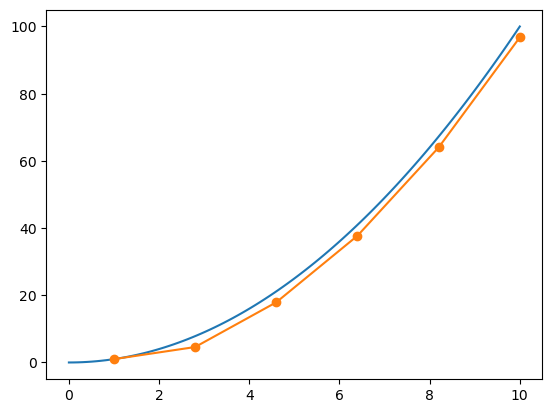

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x_init = 1
x_final = 10
n_steps = 5
step_size = (x_final - x_init) / n_steps if n_steps > 0 else x_final
ax.plot(x_grid := np.linspace(0, 10, 100), x_grid**2)

xs = np.zeros(n_steps + 1)
ys = np.zeros(n_steps + 1)
xs[0] = x_init
ys[0] = 1

for t in range(1, n_steps + 1):
    xs[t] = xs[t - 1] + step_size
    ys[t] = f(xs[t], xs[t - 1])

ax.plot(xs, ys, marker="o", label="Approximation")
plt.show()

# 2d example
Toy problem from Notes and problems from Applied General Equlibrium Economics, chapter 3

In [7]:
endog = v1, v2 = sp.symbols("v_1 v_2", real=True, positive=True)
exog = v3 = sp.symbols("v_3", real=True, positive=True)

ss_vars = v10, v20, v30 = sp.symbols("v_10 v_20 v_30", real=True, positive=True)

equations = [v1**2 * v3 - 1, v1 + v2 - 2]

In [8]:
sol = sp.solve(equations, [v1, v2], dict=True)[0]
eta = sp.Symbol("eta")
elasticities = [y.diff(v3) * v3 / x for x, y in sol.items()]

In [9]:
f_true_1 = sp.lambdify([v3], sp.solve(equations, [v1, v2])[0])
f_true = sp.lambdify([v1, v2, v3], elasticities)

In [10]:
A = sp.Matrix([[eq.diff(x) for x in endog] for eq in equations])
B = sp.Matrix([[eq.diff(x) for x in [exog]] for eq in equations])

In [31]:
B

Matrix([
[v_1**2],
[     0]])

In [45]:
sub_dict = dict(zip(endog + (exog,), ss_vars))

A_sub = A.subs(sub_dict)
Bv = B.subs(sub_dict) @ sp.Matrix([[v3]])

In [46]:
Bv

Matrix([
[v_10**2*v_3],
[          0]])

In [47]:
A_sub

Matrix([
[2*v_10*v_30, 0],
[          1, 1]])

In [48]:
v_A = -sp.Inverse(A_sub) @ Bv

In [54]:
Bv

Matrix([
[v_10**2*v_3],
[          0]])

In [50]:
import sys

sys.path.append("..")

from cge_modeling.sympy_tools import info_to_symbols, enumerate_indexbase, sub_all_eqs
from cge_modeling.production_functions import leontief, cobb_douglass
from cge_modeling.base.cge import (
    compile_cge_to_numba,
    expand_compact_system,
    recursive_solve_symbolic,
    numba_lambdify,
)
from cge_modeling.numba_tools import euler_approx

In [51]:
f_Y = numba_lambdify(exog_vars=[exog], expr=v_A, endog_vars=ss_vars)

In [55]:
f_Y(np.array([2]), np.array([1.0, 1.0, 1.0]))

array([[-1.],
       [ 1.]])

In [68]:
%timeit euler_approx(f_Y, np.array([1., 1.]), theta0=np.array([1.]), theta=np.array([2.]), n_steps=10_000)

2.18 ms ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
??euler_approx

In [40]:
v_A

Matrix([
[-v_10*v_3/(2*v_30)],
[ v_10*v_3/(2*v_30)]])

In [78]:
x0 = np.ones(2)
x0 + f_true(*x0, 2)

array([0.64644661, 1.35355339])

In [83]:
f_true_1(2)

(0.7071067811865475, 1.2928932188134525)

In [82]:
euler_approx(f_Y, np.array([1, 1]), 1, 2, 100)

array([0.70577555, 1.29422445, 2.        ])

# Simple CGE

In [84]:
def cobb_douglass(
    output: sp.Symbol, tfp: sp.Symbol, inputs: list[sp.Symbol], shares: list[sp.Symbol]
):
    if len(inputs) != len(shares):
        if (len(shares) + 1) != len(inputs):
            raise ValueError("The length of the shares should len(inputs), or len(inputs) - 1")
        shares.append(1 - sum(shares))

    return output - tfp * sp.prod([x**a for x, a in zip(inputs, shares)])

In [85]:
variables = Y, C, INC, Ld, Kd, r, P, Leon = sp.symbols(
    "Y C INC Ld Kd r P Leon", positive=True, real=True
)
parameters = Ls, Ks, A, alpha = sp.symbols("Ls Ks A alpha", positive=True, real=True)

# Numeraire
w = 1

equations = [
    cobb_douglass(Y, A, [Kd, Ld], [alpha]),
    alpha * P * Y - r * Kd,
    (1 - alpha) * P * Y - w * Ld,
    INC - w * Ls - r * Ks,
    P * C - INC,
    C - Y,
    Kd - Ks,
    Ld - Ls - Leon,
]

In [86]:
equations

[-A*Kd**alpha*Ld**(1 - alpha) + Y,
 -Kd*r + P*Y*alpha,
 -Ld + P*Y*(1 - alpha),
 INC - Ks*r - Ls,
 C*P - INC,
 C - Y,
 Kd - Ks,
 Ld - Leon - Ls]

In [87]:
A_mat = sp.Matrix([[eq.diff(x) for x in variables] for eq in equations])
B_mat = sp.Matrix([[eq.diff(x) for x in parameters] for eq in equations])

In [88]:
sub_dict = {x: sp.Symbol(f"{x.name}_0", **x._assumptions0) for x in variables + parameters}

A_sub = A_mat.subs(sub_dict)
Bv = B_mat.subs(sub_dict) @ sp.Matrix([[x] for x in parameters])

In [129]:
nb_A_sub = numba_lambdify(exog_vars=parameters, expr=A_sub, endog_vars=list(sub_dict.values()))
nb_B_sub = numba_lambdify(exog_vars=parameters, expr=Bv, endog_vars=list(sub_dict.values()))


@nb.njit
def f_dX(endog, exog):
    A = nb_A_sub(endog, exog)
    B = nb_B_sub(endog, exog)

    return -np.linalg.solve(A, np.identity(A.shape[0])) @ B

In [130]:
def compute_system(initial_dict):
    calib_dict = initial_dict.copy()
    calib_dict[INC] = (w * Ls + r * Ks).subs(calib_dict)
    calib_dict[C] = (INC / P).subs(calib_dict)
    calib_dict[Y] = (C).subs(calib_dict)
    calib_dict[Kd] = (Ks).subs(calib_dict)
    calib_dict[Ld] = (Ls).subs(calib_dict)
    calib_dict[alpha] = ((r * Kd) / (Y * P)).subs(calib_dict).evalf()
    calib_dict[A] = sp.solve(equations[0].subs(calib_dict), A)[0].evalf()
    calib_dict[Leon] = (Ld - Ls).subs(calib_dict)

    return calib_dict


init_vals = {Ls: 7000, Ks: 4000, P: 1, r: 1}
state_1 = compute_system(init_vals)
state_1

{Ls: 7000,
 Ks: 4000,
 P: 1,
 r: 1,
 INC: 11000,
 C: 11000,
 Y: 11000,
 Kd: 4000,
 Ld: 7000,
 alpha: 0.363636363636364,
 A: 1.92607022425223,
 Leon: 0}

In [131]:
theta0 = np.array([float(state_1[x]) for x in parameters])
x0 = np.array([float(state_1[x]) for x in variables])

In [104]:
# f_Y = numba_lambdify(exog_vars=parameters, expr=v_A, endog_vars=list(sub_dict.values()))

In [137]:
shock_vals = theta0 * np.array([1.1, 0, 0, 0])

In [138]:
dict(zip(sub_dict.keys(), x0 + f_dX(shock_vals, np.r_[x0, theta0]).ravel()))

{Y: 18700.000000000004,
 C: 18700.000000000004,
 INC: 23100.0,
 Ld: 14700.0,
 Kd: 4000.0,
 r: 2.1000000000000005,
 P: 1.4,
 Leon: 0.0}

In [154]:
theta0

array([7.00000000e+03, 4.00000000e+03, 1.92607022e+00, 3.63636364e-01])

In [156]:
shock_vals = theta0 * np.array([1.1, 1, 1, 1])

dict(zip(sub_dict.keys(), euler_approx(f_dX, x0, theta0, shock_vals, 10000)[:-4]))

{Y: 11687.820391434958,
 C: 11687.820391434958,
 INC: 12100.00000000582,
 Ld: 7699.99999999709,
 Kd: 4000.0,
 r: 1.1000000000006551,
 P: 1.0352659453045379,
 Leon: -2.7677860003904497e-15}